In [1]:
import json
import tensorflow
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
import keras
from numpy import array
from keras.utils import plot_model
import neurokit2 as nk
import tensorflow as tf
from skimage.restoration import denoise_wavelet
from sklearn.preprocessing import StandardScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def read_csv(filepath):
    f = open(filepath)
    data = json.load(f)
    return data

#ecg = read_csv('Preprocessed_data/ecg/ecg_unfiltered.txt')
ecg_filt = read_csv('Preprocessed_data/ecg/ecg_filtered.txt')

In [3]:
#remove first and last few minutes
for patient in ecg_filt:
    ecg_filt[patient] = ecg_filt[patient][5000:700000]
    #ecg[patient] = ecg[patient][5000:763000]

    ecg_filt[patient] = nk.ecg_clean(ecg_filt[patient], sampling_rate=62.475)

In [4]:
duration = int(10*62.4725)
segments_ecg = []

for patient in ecg_filt:
    values = ecg_filt[patient]
    for i in range(0,len(values) - duration + 1, duration):
        segments_ecg.append(values[i : (i + duration)])

In [5]:
quality = []
for i in range(len(segments_ecg)):
    try:
        quality.append(nk.ecg_quality(segments_ecg[i],
                   sampling_rate = 62.475,
                   method="zhao2018",
                   approach="simple"))
    except:
        quality.append("Invalid Input")

In [6]:
indices = np.where(np.array(quality) != "Invalid Input")[0]

normal_ecg = [segments_ecg[x] for x in indices]

In [7]:
train_df, val_df = train_test_split(normal_ecg,test_size=0.4,shuffle = True)
test_df, val_df = train_test_split(val_df,test_size=0.5,shuffle = True)

train_df = np.stack(train_df)
val_df = np.stack(val_df)
test_df = np.stack(test_df)

x_train = train_df.reshape(train_df.shape[0],train_df.shape[1], 1)
x_val = val_df.reshape(val_df.shape[0],val_df.shape[1], 1)
x_test = val_df.reshape(test_df.shape[0],test_df.shape[1], 1)

print("Training input shape: ", x_train.shape)
print("Val input shape: ", x_val.shape)
print("Test input shape: ", x_test.shape)

Training input shape:  (15503, 624, 1)
Val input shape:  (5168, 624, 1)
Test input shape:  (5168, 624, 1)


In [51]:
model = keras.Sequential(
    [
        keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        keras.layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=1, activation="relu"
        ),
        keras.layers.Dropout(rate=0.1),
        keras.layers.Conv1D(
            filters=8, kernel_size=7, padding="same", strides=1, activation="relu"
        ),
        keras.layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=1, activation="relu"
        ),
        keras.layers.Dropout(rate=0.1),
        keras.layers.Conv1DTranspose(
            filters=8, kernel_size=7, padding="same", strides=1, activation="relu"
        ),
        keras.layers.Conv1DTranspose(filters=1, kernel_size=5, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.005), loss="mae")
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_16 (Conv1D)          (None, 624, 16)           128       
                                                                 
 dropout_16 (Dropout)        (None, 624, 16)           0         
                                                                 
 conv1d_17 (Conv1D)          (None, 624, 8)            904       
                                                                 
 conv1d_transpose_24 (Conv1  (None, 624, 16)           912       
 DTranspose)                                                     
                                                                 
 dropout_17 (Dropout)        (None, 624, 16)           0         
                                                                 
 conv1d_transpose_25 (Conv1  (None, 624, 8)            904       
 DTranspose)                                          

In [52]:
history = model.fit(
    x_train,
    x_train,
    epochs=10,
    batch_size=512,
    validation_data=(x_val, x_val),
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/10
31/31 [==============================] - 17s 502ms/step - loss: 0.0295 - val_loss: 0.0076
Epoch 2/10
31/31 [==============================] - 14s 465ms/step - loss: 0.0124 - val_loss: 0.0051
Epoch 3/10
31/31 [==============================] - 15s 470ms/step - loss: 0.0105 - val_loss: 0.0048
Epoch 4/10
31/31 [==============================] - 16s 523ms/step - loss: 0.0099 - val_loss: 0.0041
Epoch 5/10
31/31 [==============================] - 14s 466ms/step - loss: 0.0093 - val_loss: 0.0034
Epoch 6/10
31/31 [==============================] - 14s 445ms/step - loss: 0.0090 - val_loss: 0.0041
Epoch 7/10
31/31 [==============================] - 15s 487ms/step - loss: 0.0088 - val_loss: 0.0033
Epoch 8/10
31/31 [==============================] - 16s 502ms/step - loss: 0.0084 - val_loss: 0.0051
Epoch 9/10
31/31 [==============================] - 16s 507ms/step - loss: 0.0084 - val_loss: 0.0055
Epoch 10/10
31/31 [==============================] - 15s 500ms/step - loss: 0.0081 - val_lo

485/485 [==============================] - 4s 9ms/step


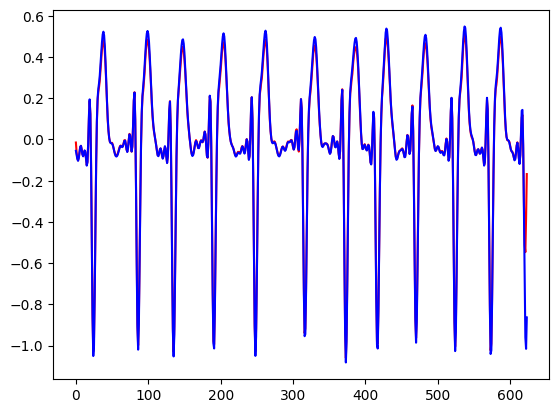

In [53]:
x_train_pred = model.predict(x_train)

# Checking how the first sequence is learnt
plt.plot(x_train_pred[20], color="red")
plt.plot(x_train[20], color="blue")

plt.show()

162/162 [==============================] - 1s 9ms/step


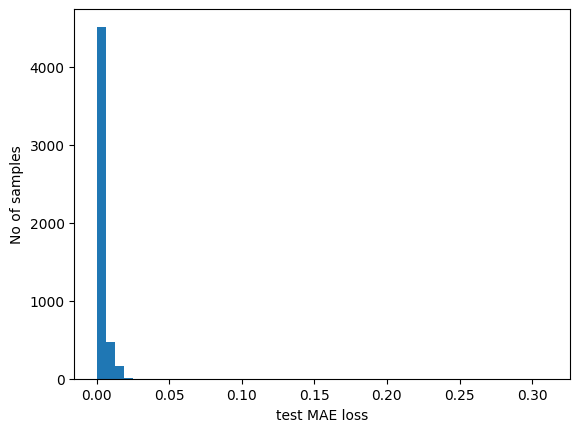

In [54]:
x_test_pred = model.predict(x_test)

# Get test MAE loss.
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()


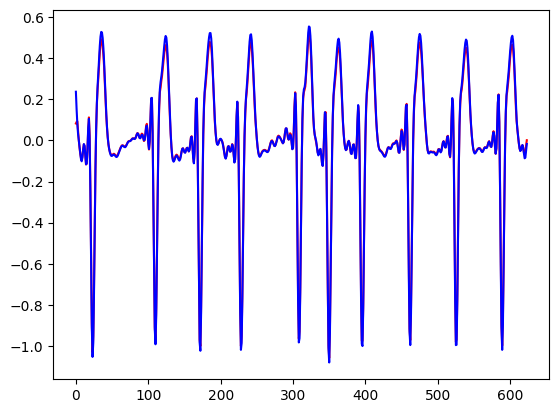

In [62]:
# Detect all the samples which are anomalies.
anomalies = test_mae_loss > 0.01

patient_num = 1

# Checking how the first sequence is learnt
plt.plot(x_test_pred[list(np.where(anomalies)[0])[patient_num]], color="red")
plt.plot(x_test[list(np.where(anomalies)[0])[patient_num]], color="blue")

plt.show()